# Data Loading + Cleaning + Merging

In [1]:
# import packages
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch, Circle
import matplotlib as mpl

import warnings
warnings.filterwarnings('ignore')

In [2]:
# load dataset
df = pd.read_csv("beam_dashboard.csv")

In [3]:
# preview dataset
df.head()

,Year,Month,State,Source,Pathogen,Serotype/Species,Number of isolates,Outbreak associated isolates,New multistate outbreaks,New multistate outbreaks - US,% Isolates with clinically important antimicrobial resistance,Number of sequenced isolates analyzed by NARMS
0,2024,1,AK,Stool,Campylobacter,jejuni,1,NaN,NaN,NaN,NaN,NaN
1,2024,1,AL,Stool,Campylobacter,coli,1,NaN,NaN,NaN,NaN,NaN
2,2024,1,AL,Stool,Campylobacter,jejuni,2,NaN,NaN,NaN,NaN,NaN
3,2024,1,AR,Stool,Campylobacter,jejuni,1,NaN,NaN,NaN,NaN,NaN
4,2024,1,CA,Stool,Campylobacter,jejuni,1,NaN,NaN,NaN,NaN,NaN


In [4]:
# drop columns to the right of 'Number of isolates' due to tons of missing / N/A data
df = df.drop(['Outbreak associated isolates', 
              'New multistate outbreaks', 
              'New multistate outbreaks - US', 
              '% Isolates with clinically important antimicrobial resistance',
              'Number of sequenced isolates analyzed by NARMS'], axis = 1)
df.head()

,Year,Month,State,Source,Pathogen,Serotype/Species,Number of isolates
0,2024,1,AK,Stool,Campylobacter,jejuni,1
1,2024,1,AL,Stool,Campylobacter,coli,1
2,2024,1,AL,Stool,Campylobacter,jejuni,2
3,2024,1,AR,Stool,Campylobacter,jejuni,1
4,2024,1,CA,Stool,Campylobacter,jejuni,1


In [5]:
# rename columns
df.columns = ['year', 'month', 'state', 'source', 'pathogen', 'serotype_species', 'num_isolates']
df.head()

,year,month,state,source,pathogen,serotype_species,num_isolates
0,2024,1,AK,Stool,Campylobacter,jejuni,1
1,2024,1,AL,Stool,Campylobacter,coli,1
2,2024,1,AL,Stool,Campylobacter,jejuni,2
3,2024,1,AR,Stool,Campylobacter,jejuni,1
4,2024,1,CA,Stool,Campylobacter,jejuni,1


In [6]:
# check for missing values
df.isna().sum()

year                0
month               0
state               5
source              0
pathogen            0
serotype_species    0
num_isolates        0
dtype: int64

In [7]:
# drop rows where state information is not available, messes up geospatial data later on
df = df.dropna()
# verify that there is no more missing data
df.isna().sum()

year                0
month               0
state               0
source              0
pathogen            0
serotype_species    0
num_isolates        0
dtype: int64

In [8]:
df['source'].unique()

array(['Stool', 'Blood', 'Other', 'Urine'], dtype=object)

In [9]:
shapefile_path = ("tl_2024_us_state/tl_2024_us_state.shp")
gdf = gpd.read_file(shapefile_path)


In [10]:
# tutorial for mapping from Oscar Leo in DEV

# define features
edge_color = "#30011E"

sns.set_style({
    "font.family": "DejaVu Sans"
})

In [11]:
# remove “unincorporated territories” such as Guam, Puerto Rico, and American Samoa
states = gdf[~gdf.STATEFP.isin(["72", "69", "60", "66", "78"])]

# adjust the state mapping projection
states = states.to_crs("ESRI:102003")

In [12]:
# translating data to draw Alaska and Hawaii under mainland USA (just for aesthetic purposes!)
def translate_geometries(df, x, y, scale, rotate):
    df.loc[:, "geometry"] = df.geometry.translate(yoff = y, xoff = x)
    center = df.dissolve().centroid.iloc[0]
    df.loc[:, "geometry"] = df.geometry.scale(xfact = scale, yfact = scale, origin = center)
    df.loc[:, "geometry"] = df.geometry.rotate(rotate, origin = center)
    return df

In [13]:
# separates Hawaii and Alaska to adjust their geometries
def adjust_maps(df):
    df_main_land = df[~df.STATEFP.isin(["02", "15"])]
    df_alaska = df[df.STATEFP == "02"]
    df_hawaii = df[df.STATEFP == "15"]
    
    # putting them back into new dataframes
    df_alaska = translate_geometries(df_alaska, 1300000, -4900000, 0.5, 32)
    df_hawaii = translate_geometries(df_hawaii, 5400000, -1500000, 1, 24)

    return pd.concat([df_main_land, df_alaska, df_hawaii])

In [14]:
# adding adjust_maps to the code
states = adjust_maps(states)

In [15]:
# merging shapefiles to the data
merged_df = df.merge(states, left_on='state', right_on='STUSPS')

In [16]:
merged_df.head()

,year,month,state,source,pathogen,serotype_species,num_isolates,REGION,DIVISION,STATEFP,...,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,2024,1,AK,Stool,Campylobacter,jejuni,1,4,9,02,...,AK,Alaska,00,G4000,A,1479508971743,244710526650,+63.3473560,-152.8397334,"MULTIPOLYGON (((-2778499.467 -1620603.792, -27..."
1,2024,1,AL,Stool,Campylobacter,coli,1,3,6,01,...,AL,Alabama,00,G4000,A,131185561946,4581813708,+32.7395785,-086.8434469,"POLYGON ((1023282.917 -582853.454, 1023269.168..."
2,2024,1,AL,Stool,Campylobacter,jejuni,2,3,6,01,...,AL,Alabama,00,G4000,A,131185561946,4581813708,+32.7395785,-086.8434469,"POLYGON ((1023282.917 -582853.454, 1023269.168..."
3,2024,1,AR,Stool,Campylobacter,jejuni,1,3,7,05,...,AR,Arkansas,00,G4000,A,134658517854,3122715710,+34.8955256,-092.4446262,"POLYGON ((461603.731 -366288.124, 461727.959 -..."
4,2024,1,CA,Stool,Campylobacter,jejuni,1,4,9,06,...,CA,California,00,G4000,A,403673433805,20291632828,+37.1551773,-119.5434183,"MULTIPOLYGON (((-1976277.366 663684.581, -1976..."


In [17]:
merged_df.columns

Index(['year', 'month', 'state', 'source', 'pathogen', 'serotype_species',
       'num_isolates', 'REGION', 'DIVISION', 'STATEFP', 'STATENS', 'GEOID',
       'GEOIDFQ', 'STUSPS', 'NAME', 'LSAD', 'MTFCC', 'FUNCSTAT', 'ALAND',
       'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry'],
      dtype='object')

In [18]:
# keeping certain columns for EDA
merged_df = merged_df[['year', 'month', 'state', 'source', 'pathogen', 'serotype_species', 'num_isolates', 'geometry']]
merged_df.head()

,year,month,state,source,pathogen,serotype_species,num_isolates,geometry
0,2024,1,AK,Stool,Campylobacter,jejuni,1,"MULTIPOLYGON (((-2778499.467 -1620603.792, -27..."
1,2024,1,AL,Stool,Campylobacter,coli,1,"POLYGON ((1023282.917 -582853.454, 1023269.168..."
2,2024,1,AL,Stool,Campylobacter,jejuni,2,"POLYGON ((1023282.917 -582853.454, 1023269.168..."
3,2024,1,AR,Stool,Campylobacter,jejuni,1,"POLYGON ((461603.731 -366288.124, 461727.959 -..."
4,2024,1,CA,Stool,Campylobacter,jejuni,1,"MULTIPOLYGON (((-1976277.366 663684.581, -1976..."


# EDA

### Analyzing the number of cases per year

In [19]:
counts_per_year = merged_df.groupby(['year', 'pathogen']).size().unstack(fill_value=0)
counts_per_year['Total'] = counts_per_year['Campylobacter'] + counts_per_year['STEC'] + counts_per_year['Salmonella'] + counts_per_year['Shigella'] + counts_per_year['Vibrio']
counts_per_year.head()

pathogen,Campylobacter,STEC,Salmonella,Shigella,Vibrio,Total
year,,,,,,
2018,737,0,18114,0,137,18988
2019,650,0,17634,0,175,18459
2020,473,0,15037,0,130,15640
2021,481,0,16215,0,168,16864
2022,553,0,15810,0,256,16619


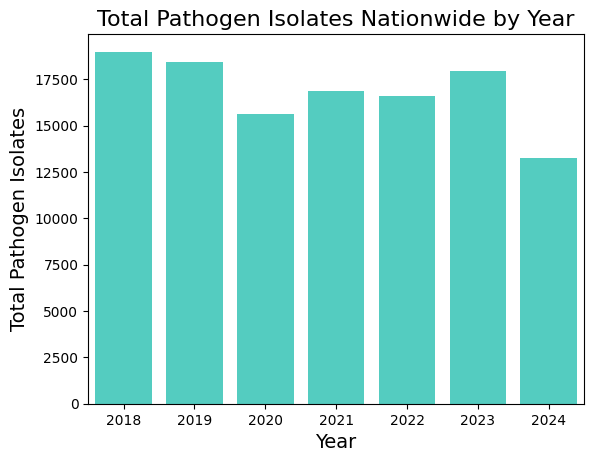

In [20]:
# visualizing total pathogen isolates nationwide by year
sns.barplot(x='year', y='Total', data=counts_per_year, color='turquoise')
plt.title('Total Pathogen Isolates Nationwide by Year', fontsize = 16)
plt.xlabel('Year', fontsize = 14)
plt.ylabel('Total Pathogen Isolates', fontsize = 14)
plt.show()

### Analyzing the number of cases per pathogen type per month

In [21]:
# create a dataframe counts_per_month
counts_per_month = merged_df.groupby(['month', 'pathogen']).size().unstack(fill_value=0)
counts_per_month['Total'] = counts_per_month['Campylobacter'] + counts_per_month['STEC'] + counts_per_month['Salmonella'] + counts_per_month['Shigella'] + counts_per_month['Vibrio']
counts_per_month.head()

pathogen,Campylobacter,STEC,Salmonella,Shigella,Vibrio,Total
month,,,,,,
1,335,0,8108,0,43,8486
2,310,0,6880,0,36,7226
3,321,0,7680,2,53,8056
4,333,1,8395,2,50,8781
5,369,0,9861,2,90,10322


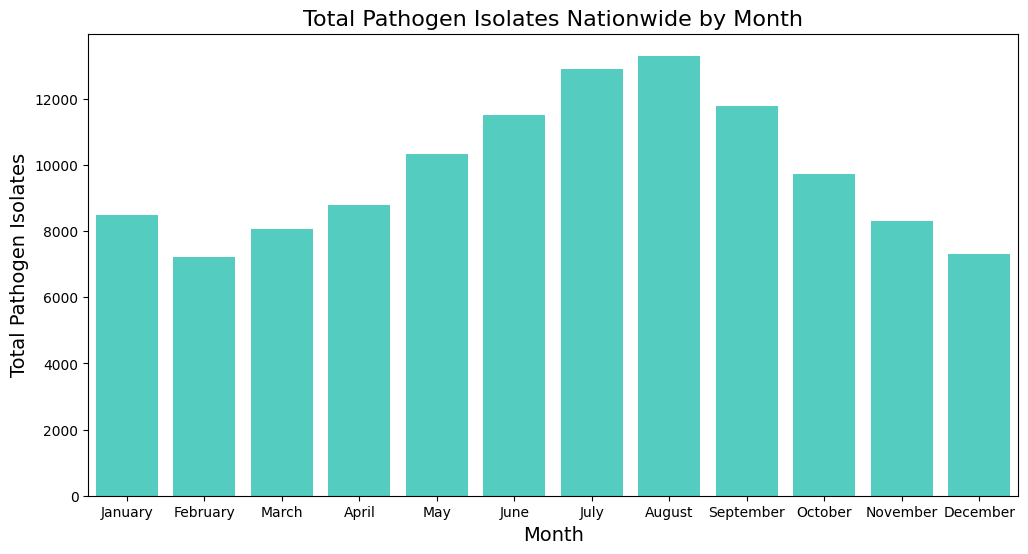

In [22]:
# visualizing total pathogen isolates nationwide by month
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='month', y='Total', data=counts_per_month, color='turquoise')
plt.title('Total Pathogen Isolates Nationwide by Month', fontsize=16)
plt.xlabel('Month', fontsize = 14)
ax.set_xticklabels(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
plt.ylabel('Total Pathogen Isolates', fontsize = 14)
plt.show()

### Analyzing the cases per quarter (i.e. 2018 Q1, 2018 Q2, etc.)

In [23]:
merged_df['date'] = pd.to_datetime(merged_df[['year', 'month']].assign(day=1))

# group by quarter and sum num_isolates
quarterly_data = (
    merged_df.groupby(pd.Grouper(key='date', freq='Q'))['num_isolates']
    .sum()
    .reset_index()
)

# rename columns for clarity
quarterly_data.rename(columns={'date': 'quarter', 'num_isolates': 'total_isolates'}, inplace=True)

quarterly_data.head()

,quarter,total_isolates
0,2018-03-31,8268
1,2018-06-30,13954
2,2018-09-30,21647
3,2018-12-31,12663
4,2019-03-31,7955


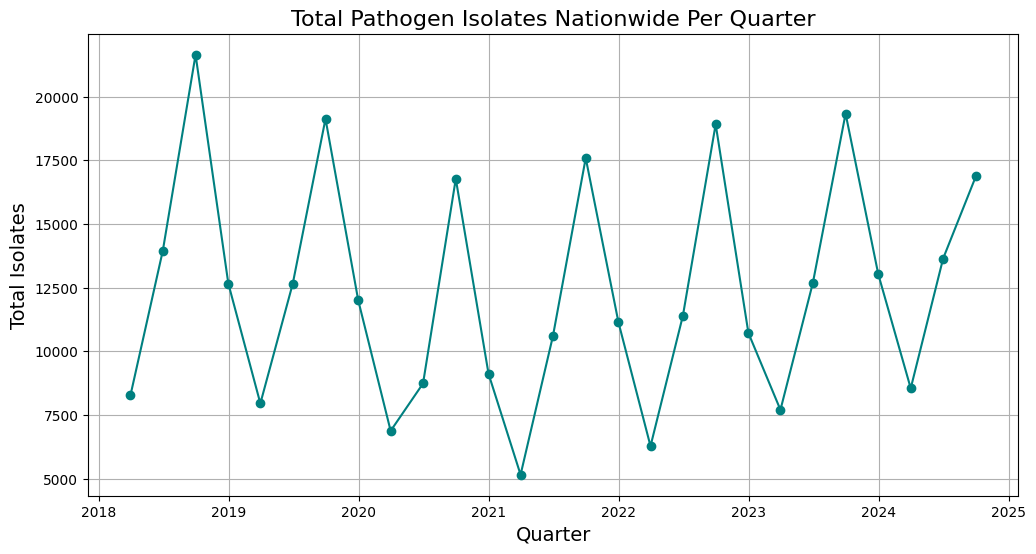

In [24]:
# plot quarterly sum of isolates
plt.figure(figsize=(12, 6))
plt.plot(quarterly_data['quarter'], quarterly_data['total_isolates'], marker='o', linestyle='-', color='teal')
plt.title('Total Pathogen Isolates Nationwide Per Quarter', fontsize = 16)
plt.xlabel('Quarter', fontsize = 14)
plt.ylabel('Total Isolates', fontsize = 14)
plt.grid(True)
plt.show()

### Analyzing the cases per source type

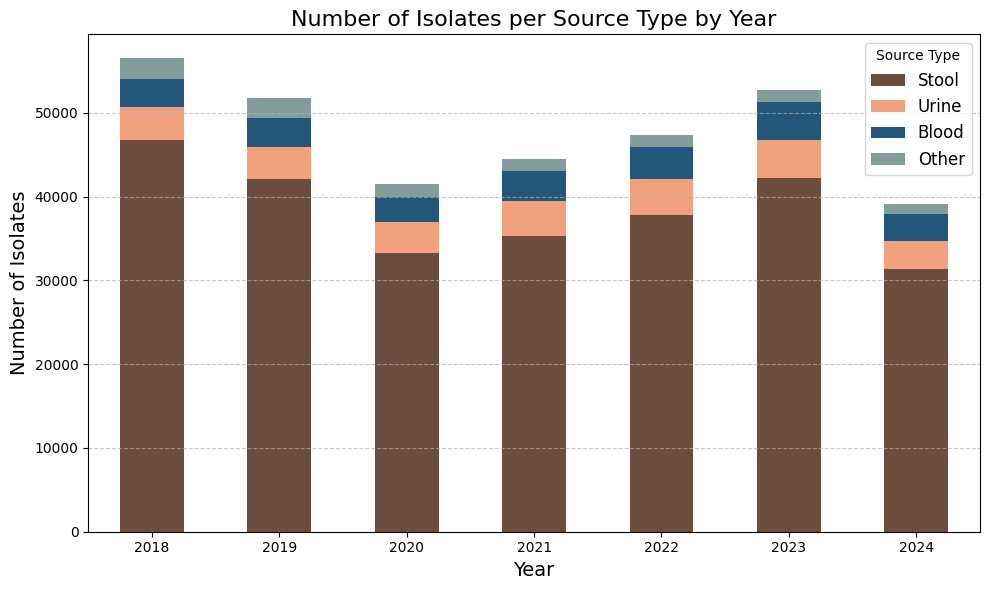

In [25]:
# Step 1: Group and pivot the data as before
cases_per_source = merged_df.groupby(['year', 'source'])['num_isolates'].sum().reset_index()
pivot_table = cases_per_source.pivot(index='year', columns='source', values='num_isolates').fillna(0)

# Step 2: Reorder columns based on the total sum
pivot_table = pivot_table[pivot_table.sum(axis=0).sort_values(ascending=False).index]

# Step 3: Plot the stacked bar plot with reordered columns
pivot_table.plot(kind='bar', stacked=True, figsize=(10, 6), rot = 0, color = ['#6D4C3D', '#F1A17E', '#22577A', '#839D9A'])

# Add titles and labels
plt.title('Number of Isolates per Source Type by Year', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Isolates', fontsize=14)
plt.legend(title='Source Type', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()

## Geospatial Analyses

### Analyzing total outbreaks per state

In [26]:
import geopandas as gpd
geo_df = gpd.GeoDataFrame(merged_df, geometry='geometry')


tried to run the following code, but my kernel kept crashing -sophia

In [27]:
# # Plot the map
# fig, ax = plt.subplots(1, 1, figsize=(15, 10))
# geo_df.plot(
#     column='num_isolates',
#     cmap='YlGnBu',
#     legend=True,
#     ax=ax
# )

# # Customize legend
# legend = ax.get_legend()
# if legend is not None:
#     legend.set_title("Total Outbreaks")

# # Annotate the map with the number of outbreaks
# for x, y, label in zip(geo_df.geometry.centroid.x, geo_df.geometry.centroid.y, geo_df['num_isolates']):
#     ax.text(x, y, str(int(label)), fontsize=8, ha='center', va='center')

# plt.title("US States - Total Pathogen Outbreaks")
# plt.axis('off')
# plt.show()

In [28]:
# Preview the geometry column
# print(geo_df['geometry'].head())  
# Check if all geometries are valid
# print(geo_df['geometry'].is_valid)  

In [29]:
merged_df.head()

,year,month,state,source,pathogen,serotype_species,num_isolates,geometry,date
0,2024,1,AK,Stool,Campylobacter,jejuni,1,"MULTIPOLYGON (((-2778499.467 -1620603.792, -27...",2024-01-01
1,2024,1,AL,Stool,Campylobacter,coli,1,"POLYGON ((1023282.917 -582853.454, 1023269.168...",2024-01-01
2,2024,1,AL,Stool,Campylobacter,jejuni,2,"POLYGON ((1023282.917 -582853.454, 1023269.168...",2024-01-01
3,2024,1,AR,Stool,Campylobacter,jejuni,1,"POLYGON ((461603.731 -366288.124, 461727.959 -...",2024-01-01
4,2024,1,CA,Stool,Campylobacter,jejuni,1,"MULTIPOLYGON (((-1976277.366 663684.581, -1976...",2024-01-01


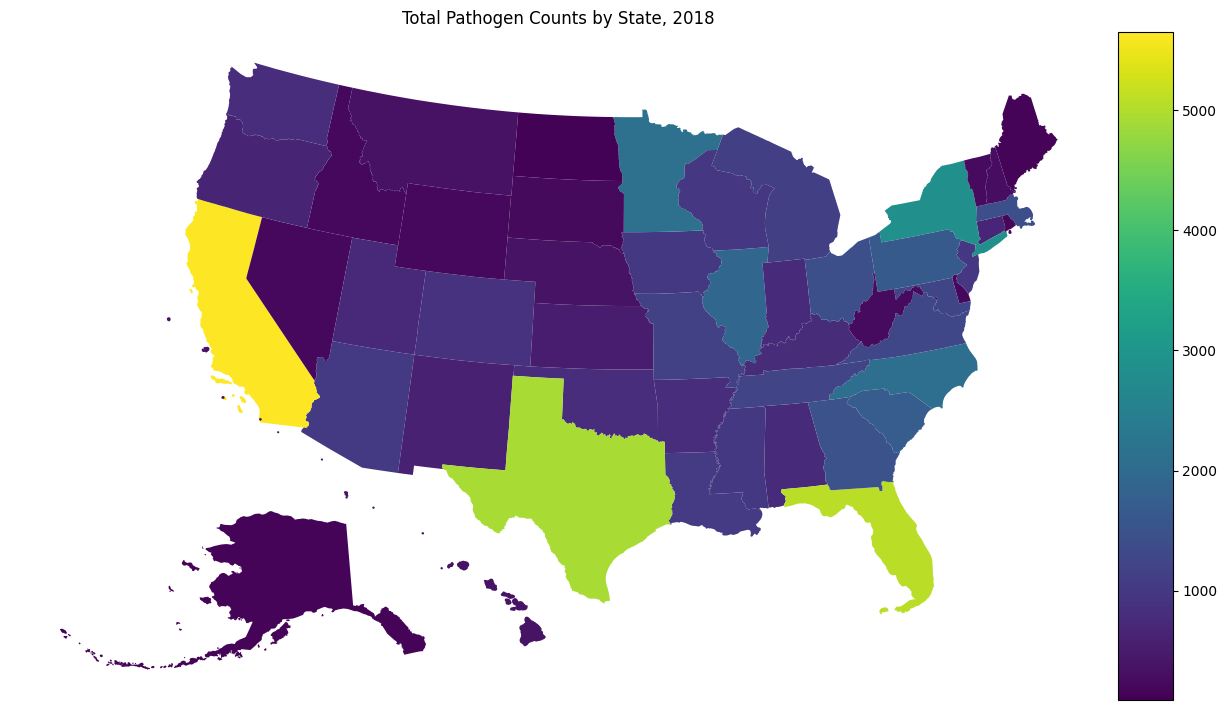

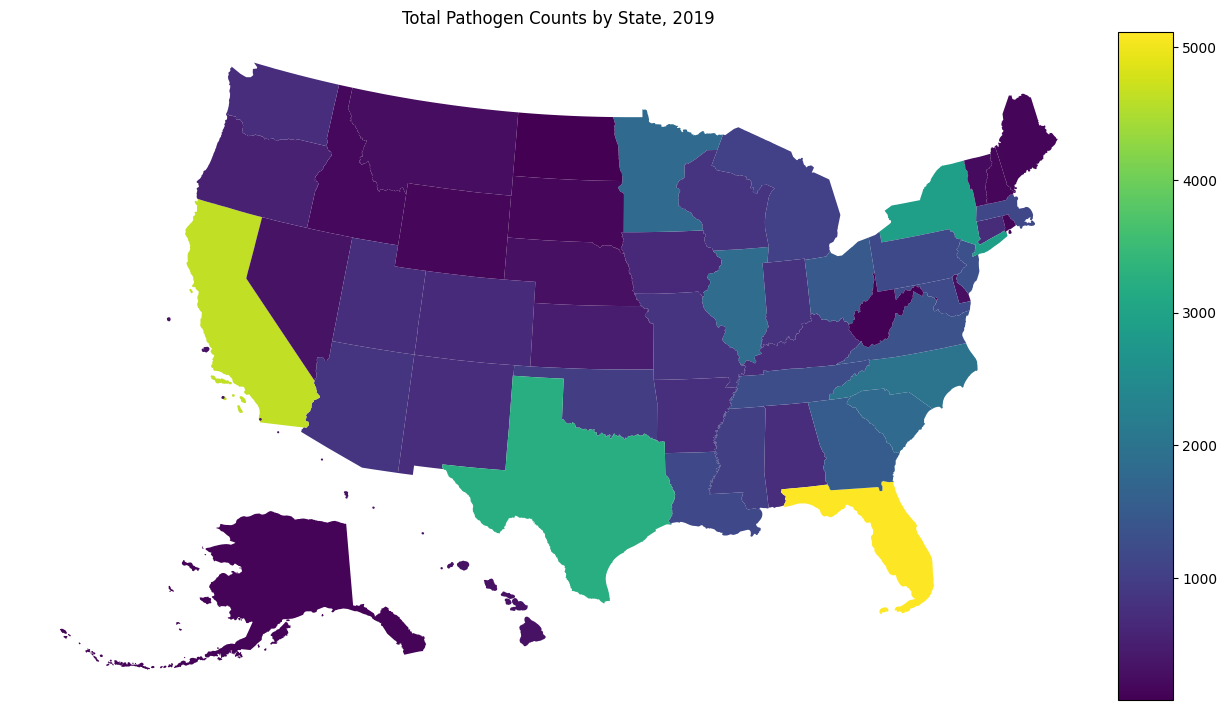

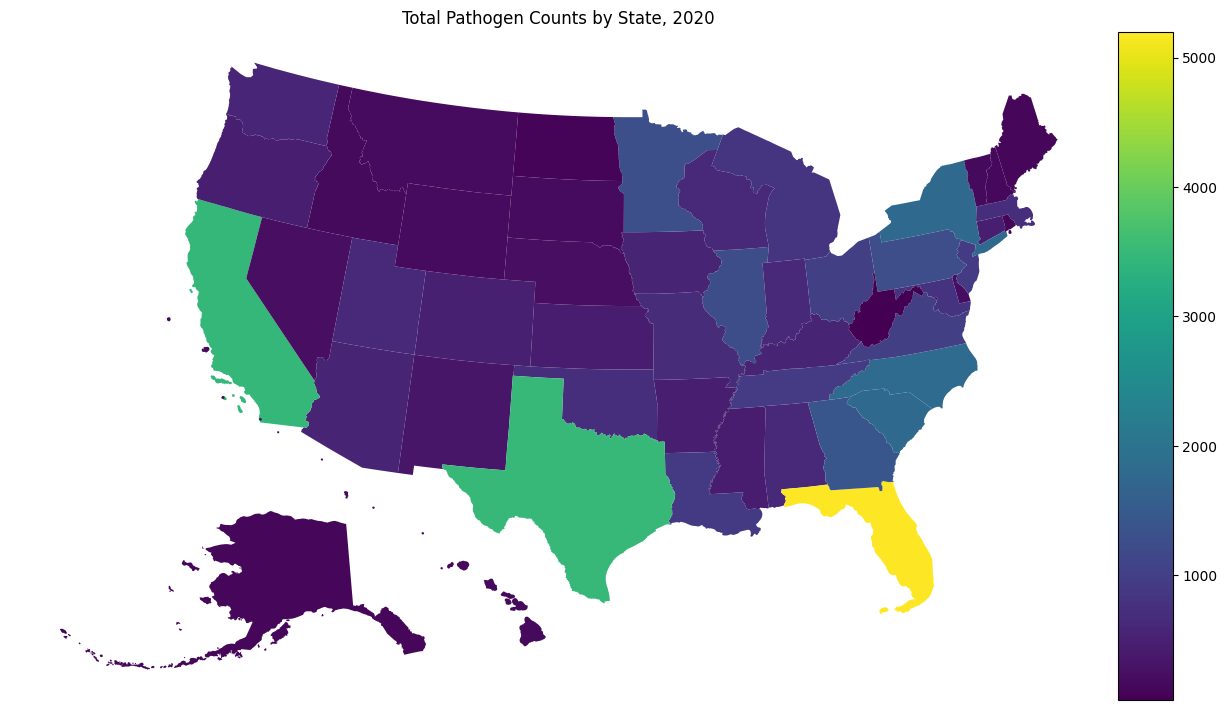

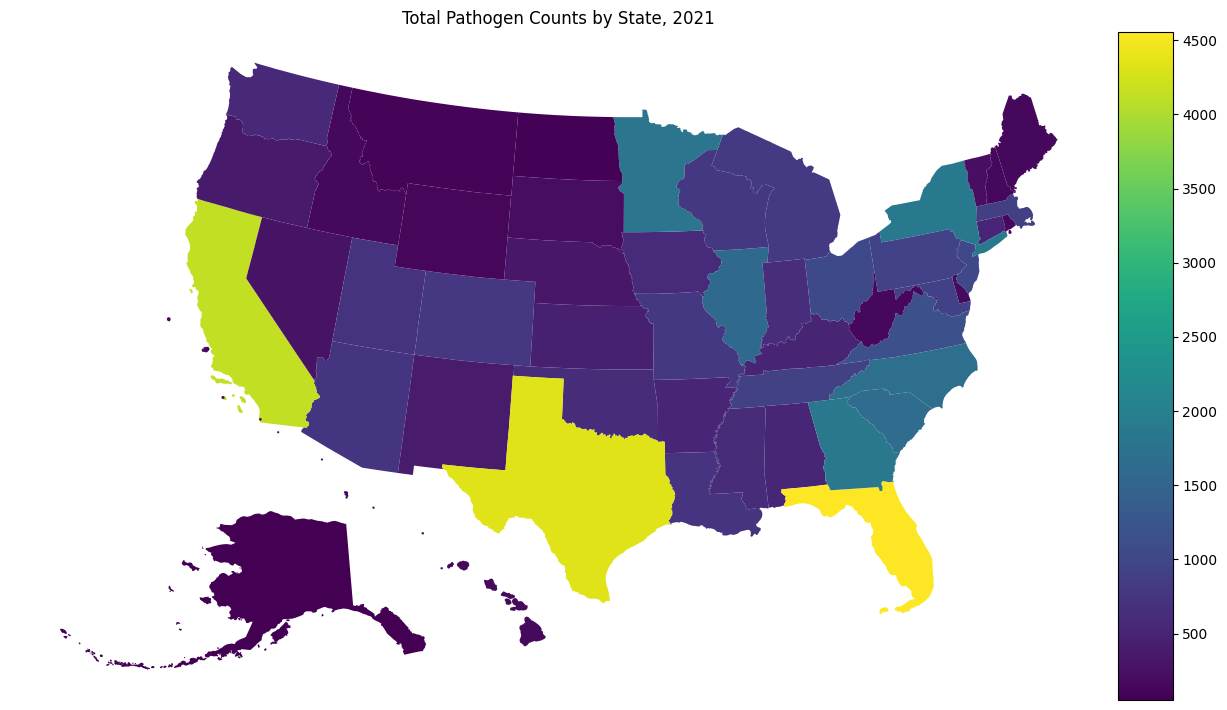

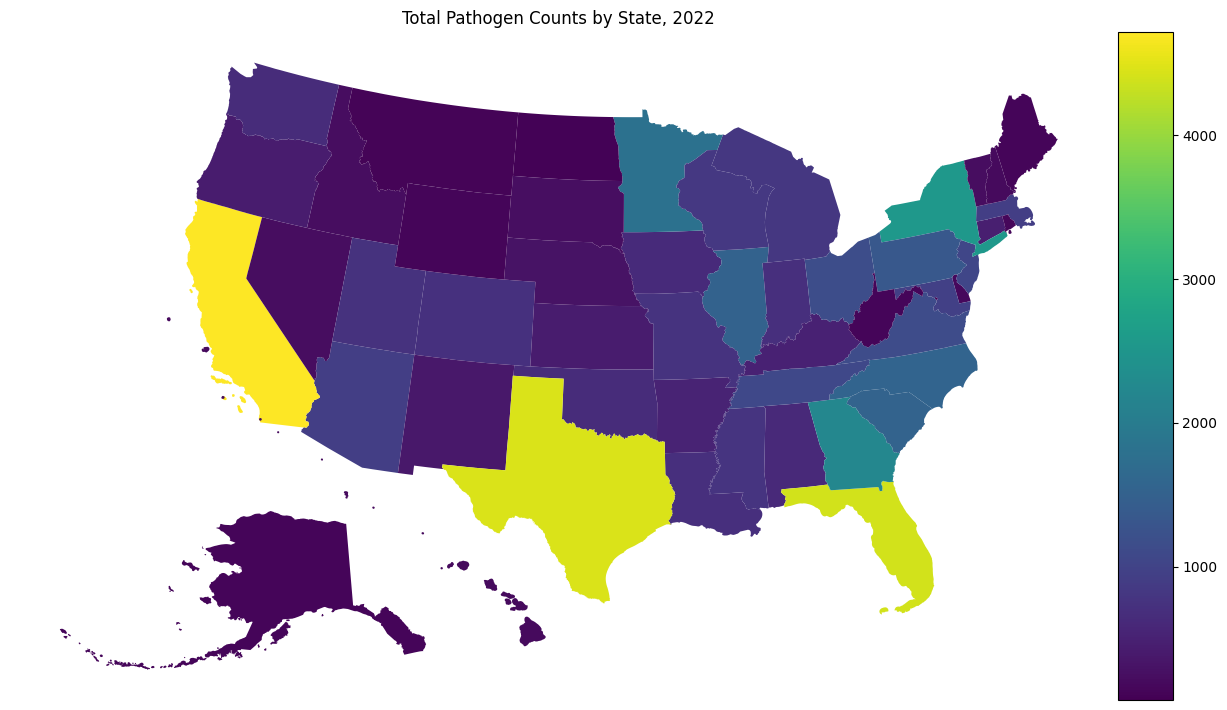

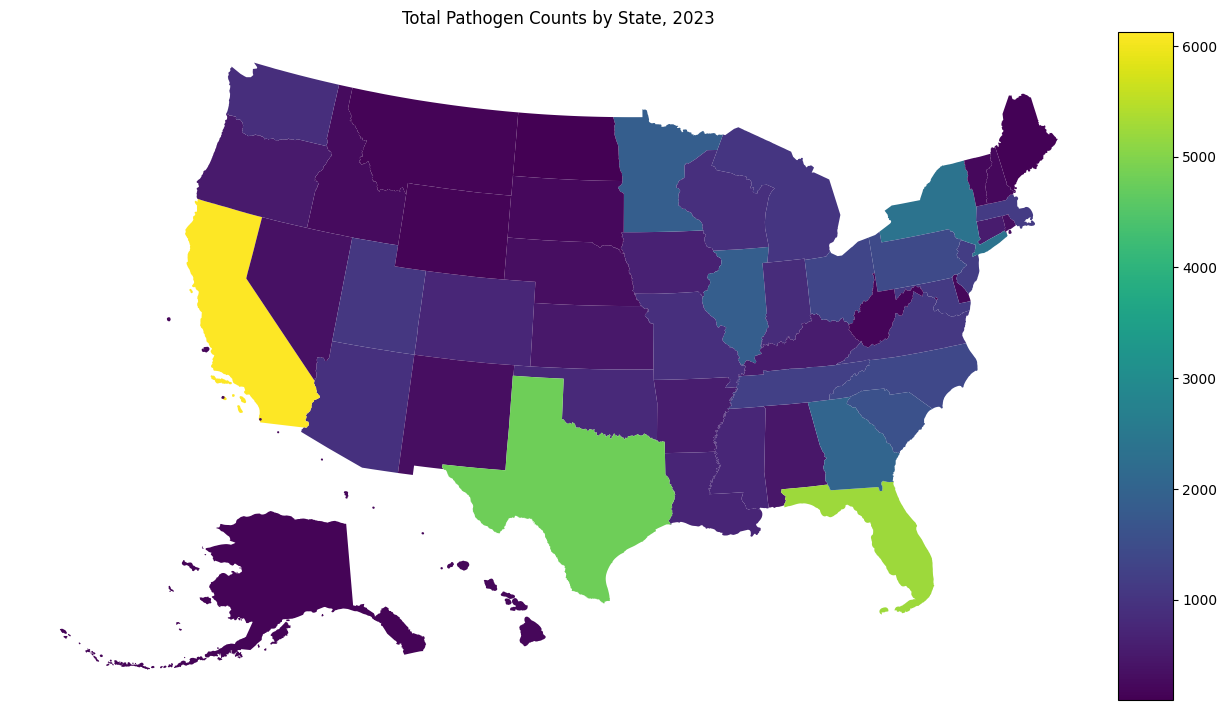

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

merged_df['num_isolates'] = merged_df['num_isolates'].astype(int)
# sum the isolates by year and state
annual_state_isolates = merged_df.groupby(['year', 'state']).agg({'num_isolates': 'sum', 'geometry': 'first'}).reset_index()

# convert GeoDataFrame
annual_state_isolates = gpd.GeoDataFrame(annual_state_isolates, geometry='geometry')

# maps for each year from 2018 to 2023
years = range(2018, 2024)
for year in years:
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))

    year_data = annual_state_isolates[annual_state_isolates['year'] == year]


    # legend adjustments
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    
    plot = year_data.plot(column='num_isolates', ax=ax, legend=True, cax=cax)
    ax.set_title(f'Total Pathogen Counts by State, {year}')
    ax.set_axis_off()
    plt.show()